# Notebook pour l'entrainement d'un modèle

## Importation des librairies

In [89]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest
import sklearn
from utils import text_to_numeric, get_upper_matrix, get_correlated, create_pipeline, remove_redundancy
import matplotlib.pyplot as plt
import seaborn as sns

---

## Importation des données

In [90]:
df_sirh = pd.read_csv("../data/extrait_sirh.csv")
df_sondage = pd.read_csv("../data/extrait_sondage.csv")
df_eval = pd.read_csv("../data/extrait_eval.csv")

In [91]:
df_sirh.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,6,4
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,10,7
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,0,0
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,8,7
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,2,2


In [92]:
df_sondage.head()

,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,nombre_employee_sous_responsabilite,code_sondage,distance_domicile_travail,niveau_education,domaine_etude,ayant_enfants,frequence_deplacement,annees_depuis_la_derniere_promotion,annes_sous_responsable_actuel
0,Oui,0,0,1,1,1,2,Infra & Cloud,Y,Occasionnel,0,5
1,Non,1,3,1,2,8,1,Infra & Cloud,Y,Frequent,1,7
2,Oui,0,3,1,4,2,2,Autre,Y,Occasionnel,0,0
3,Non,0,3,1,5,3,4,Infra & Cloud,Y,Frequent,3,0
4,Non,1,3,1,7,2,1,Transformation Digitale,Y,Occasionnel,2,2


In [93]:
df_eval.head()

,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,2,3,2,4,1,1,E_1,3,Oui,11 %
1,3,2,2,2,4,3,E_2,4,Non,23 %
2,4,2,1,3,2,3,E_4,3,Oui,15 %
3,4,3,1,3,3,3,E_5,3,Oui,11 %
4,1,3,1,2,4,3,E_7,3,Non,12 %


---

## Préparation de la data

---
### Préparation pour le merge des DF

In [94]:
df_eval['eval_number'] = text_to_numeric(df_eval['eval_number'])
df_eval.dtypes

satisfaction_employee_environnement           int64
note_evaluation_precedente                    int64
niveau_hierarchique_poste                     int64
satisfaction_employee_nature_travail          int64
satisfaction_employee_equipe                  int64
satisfaction_employee_equilibre_pro_perso     int64
eval_number                                   int64
note_evaluation_actuelle                      int64
heure_supplementaires                        object
augementation_salaire_precedente             object
dtype: object

In [95]:
df_sirh.dtypes

id_employee                        int64
age                                int64
genre                             object
revenu_mensuel                     int64
statut_marital                    object
departement                       object
poste                             object
nombre_experiences_precedentes     int64
nombre_heures_travailless          int64
annee_experience_totale            int64
annees_dans_l_entreprise           int64
annees_dans_le_poste_actuel        int64
dtype: object

In [96]:
df_sondage.dtypes

a_quitte_l_entreprise                  object
nombre_participation_pee                int64
nb_formations_suivies                   int64
nombre_employee_sous_responsabilite     int64
code_sondage                            int64
distance_domicile_travail               int64
niveau_education                        int64
domaine_etude                          object
ayant_enfants                          object
frequence_deplacement                  object
annees_depuis_la_derniere_promotion     int64
annes_sous_responsable_actuel           int64
dtype: object

---
### Merge des dataframes

In [97]:
df_first_merge = pd.merge(df_sirh, df_sondage, how='outer', left_on='id_employee', right_on='code_sondage', indicator=True)
print(f"Il y a {len(df_first_merge['_merge'] == 'both')} correspondances sur {len(df_first_merge)}")
df_first_merge.drop(columns=['_merge'], inplace=True)

Il y a 1470 correspondances sur 1470


In [98]:
df_data = pd.merge(df_first_merge, df_eval, how='outer', left_on='id_employee', right_on='eval_number', indicator=True)
print(f"Il y a {len(df_data['_merge'] == 'both')} correspondances sur {len(df_data)}")
df_data.drop(columns=['_merge'], inplace=True)

Il y a 1470 correspondances sur 1470


In [99]:
df_data.head()

,id_employee,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,nombre_heures_travailless,annee_experience_totale,...,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,eval_number,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,1,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,80,8,...,2,3,2,4,1,1,1,3,Oui,11 %
1,2,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,80,10,...,3,2,2,2,4,3,2,4,Non,23 %
2,4,37,M,2090,Célibataire,Consulting,Consultant,6,80,7,...,4,2,1,3,2,3,4,3,Oui,15 %
3,5,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,80,8,...,4,3,1,3,3,3,5,3,Oui,11 %
4,7,27,M,3468,Marié(e),Consulting,Consultant,9,80,6,...,1,3,1,2,4,3,7,3,Non,12 %


---
### Pipeline d'encodage de la data

In [100]:
useless_columns = [
    "id_employee",
    "eval_number",
    "code_sondage",
    "nombre_heures_travailless",
    "nombre_employee_sous_responsabilite",
    "ayant_enfants",
]

target_column = "a_quitte_l_entreprise"

category_columns = [
    "genre",
    "statut_marital",
    "departement",
    "poste",
    "domaine_etude",
    "heure_supplementaires",
]

ordinales_columns = [
    "frequence_deplacement",
]

ordinales_categories = [
    ["Aucun", "Occasionnel", "Frequent"],
]

numeric_columns = [
    "revenu_mensuel",
    "age",
    "nombre_experiences_precedentes",
    "annee_experience_totale",
    "annees_dans_l_entreprise",
    "annees_dans_le_poste_actuel",
    "nombre_participation_pee",
    "nb_formations_suivies",
    "distance_domicile_travail",
    "niveau_education",
    "annees_depuis_la_derniere_promotion",
    "annes_sous_responsable_actuel",
    "satisfaction_employee_environnement",
    "note_evaluation_precedente",
    "niveau_hierarchique_poste",
    "satisfaction_employee_nature_travail",
    "satisfaction_employee_equipe",
    "satisfaction_employee_equilibre_pro_perso",
    "note_evaluation_actuelle",
]

In [101]:
sklearn.set_config(transform_output="pandas")

text_pipeline = Pipeline(
    [
        ("clean", FunctionTransformer(text_to_numeric, feature_names_out="one-to-one")),
        ("scale", StandardScaler()),
    ]
)

ordinal_pipeline = Pipeline(
    [
        ("encode", OrdinalEncoder(categories=ordinales_categories)),
        ("scale", StandardScaler()),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        # OneHotEncoder, n-1 to avoid redundancy with drop first
        ("oneHot", OneHotEncoder(drop="first", sparse_output=False), category_columns),
        # Managing all OrdinalEncoder
        (
            "ordinal",
            ordinal_pipeline,
            ordinales_columns,
        ),
        # Special pipeline for text to numeric
        ("textToNumeric", text_pipeline, ["augementation_salaire_precedente"]),
        # Standard Scaler
        ("scaler", StandardScaler(), numeric_columns),
    ]
)

In [102]:
df_data[target_column] = df_data[target_column].map({'Non': 0, 'Oui': 1})
df_data.drop(columns=useless_columns)

,age,genre,revenu_mensuel,statut_marital,departement,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,annees_dans_le_poste_actuel,...,annes_sous_responsable_actuel,satisfaction_employee_environnement,note_evaluation_precedente,niveau_hierarchique_poste,satisfaction_employee_nature_travail,satisfaction_employee_equipe,satisfaction_employee_equilibre_pro_perso,note_evaluation_actuelle,heure_supplementaires,augementation_salaire_precedente
0,41,F,5993,Célibataire,Commercial,Cadre Commercial,8,8,6,4,...,5,2,3,2,4,1,1,3,Oui,11 %
1,49,M,5130,Marié(e),Consulting,Assistant de Direction,1,10,10,7,...,7,3,2,2,2,4,3,4,Non,23 %
2,37,M,2090,Célibataire,Consulting,Consultant,6,7,0,0,...,0,4,2,1,3,2,3,3,Oui,15 %
3,33,F,2909,Marié(e),Consulting,Assistant de Direction,1,8,8,7,...,0,4,3,1,3,3,3,3,Oui,11 %
4,27,M,3468,Marié(e),Consulting,Consultant,9,6,2,2,...,2,1,3,1,2,4,3,3,Non,12 %
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,M,2571,Marié(e),Consulting,Consultant,4,17,5,2,...,3,3,4,2,4,3,3,3,Non,17 %
1466,39,M,9991,Marié(e),Consulting,Manager,4,9,7,7,...,7,4,2,3,1,1,3,3,Non,15 %
1467,27,M,6142,Marié(e),Consulting,Tech Lead,1,6,6,2,...,3,2,4,2,2,2,3,4,Oui,20 %
1468,49,M,5390,Marié(e),Commercial,Cadre Commercial,2,17,9,6,...,8,4,2,2,2,4,2,3,Non,14 %


In [103]:
df_data[target_column].head()

0    1
1    0
2    1
3    0
4    0
Name: a_quitte_l_entreprise, dtype: int64

## Test des modèles avec des données brutes

In [104]:
models = {
    "Dummy": DummyClassifier(strategy="most_frequent"),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

results = {}

In [105]:
X = df_data.drop(columns=target_column)
y = df_data[target_column]

In [106]:
for name, model in models.items():
    pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", model)])

    scores = cross_val_score(pipeline, X, y, cv=5, scoring='f1')
    results[name] = scores

In [107]:
for name, score in results.items():
    print(f"{name} score: {score}")

Dummy score: [0. 0. 0. 0. 0.]
Logistic Regression score: [0.57142857 0.51428571 0.51948052 0.5        0.59459459]
Random Forest score: [0.1509434  0.30508475 0.34482759 0.21428571 0.27586207]


### Détection des features à hautes corrélations

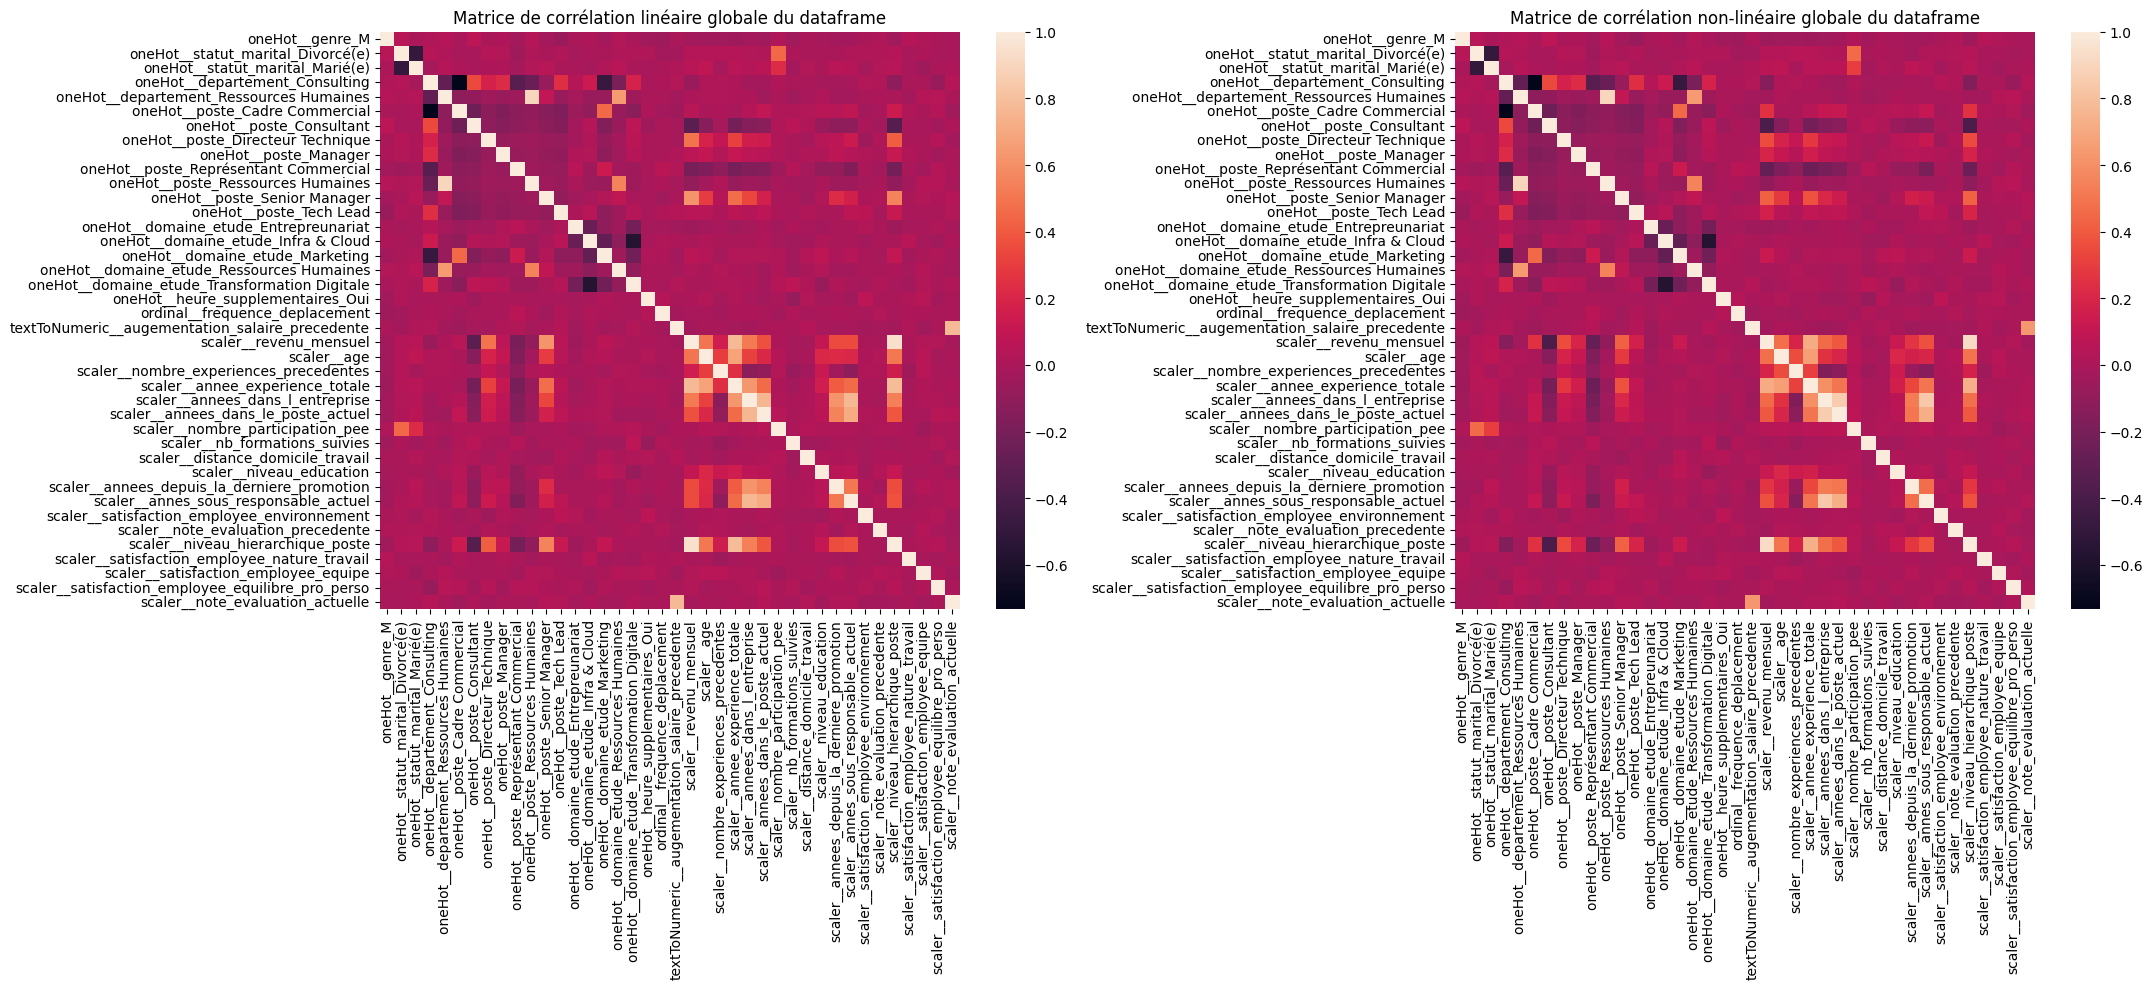

In [108]:
X_transformed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

df_transformed = pd.DataFrame(X_transformed, columns=feature_names)

correlation_matrix = df_transformed.corr(method='pearson')
spearman_correlation_matrix = df_transformed.corr(method='spearman')

fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(correlation_matrix, ax=axes[0])
axes[0].set_title("Matrice de corrélation linéaire globale du dataframe")

sns.heatmap(spearman_correlation_matrix, ax=axes[1])
axes[1].set_title("Matrice de corrélation non-linéaire globale du dataframe")
plt.tight_layout()

In [109]:
upper_linear_matrix_part = get_upper_matrix(correlation_matrix)
upper_non_linear_matrix_part = get_upper_matrix(spearman_correlation_matrix)

potential_dropped_linear_features = get_correlated(upper_linear_matrix_part)
potential_dropped_non_linear_features = get_correlated(upper_non_linear_matrix_part)

print(f"Nombre de colonnes avec une corrélation linéaire élevées: {len(potential_dropped_linear_features)}")
print(f"Nombre de colonnes avec une corrélation non linéaire élevées: {len(potential_dropped_non_linear_features)}")
print(f"Colonnes potentielles à drop:\n\tlinear:{potential_dropped_linear_features}\n\tnon linear {potential_dropped_non_linear_features}")

Nombre de colonnes avec une corrélation linéaire élevées: 2
Nombre de colonnes avec une corrélation non linéaire élevées: 2
Colonnes potentielles à drop:
	linear:['oneHot__poste_Ressources Humaines', 'scaler__niveau_hierarchique_poste']
	non linear ['oneHot__poste_Ressources Humaines', 'scaler__niveau_hierarchique_poste']


## Test des modèles avec un apprentissage non optimisé

In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

pipelines = {}

for name, model in models.items():
    pipelines[name] = create_pipeline(
        preprocessor=preprocessor, model_name=name, model=model
    )

    pipelines[name].fit(X_train, y_train)

In [111]:
for name, pipeline in pipelines.items():
    y_pred = pipeline.predict(X_test)
    print(f"\n--- Rapport pour {name} ---")
    print(classification_report(y_test, y_pred))


--- Rapport pour Dummy ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294


--- Rapport pour Logistic Regression ---
              precision    recall  f1-score   support

           0       0.89      0.96      0.93       247
           1       0.68      0.40      0.51        47

    accuracy                           0.87       294
   macro avg       0.79      0.68      0.72       294
weighted avg       0.86      0.87      0.86       294


--- Rapport pour Random Forest ---
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       247
           1       1.00      0.21      0.35        47

    accuracy                           0.87       294
   macro avg       0.9

c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

## Test des modèles avec les features redondantes en moins

In [112]:
pipelines_without_redundancy = {}

redundancy_selector = (
    "redundancy",
    FunctionTransformer(
        remove_redundancy,
        kw_args={"columns": potential_dropped_linear_features},
        validate=False,
    ),
)

for name, model in models.items():
    pipelines_without_redundancy[name] = create_pipeline(
        preprocessor=preprocessor,
        model=model,
        model_name=name,
        extra_steps=[redundancy_selector],
    )

    pipelines_without_redundancy[name].fit(X_train, y_train)

In [113]:
for name, pipeline in pipelines_without_redundancy.items():
    y_pred = pipeline.predict(X_test)
    print(f"\n--- Rapport pour {name} ---")
    print(classification_report(y_test, y_pred))


--- Rapport pour Dummy ---
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       247
           1       0.00      0.00      0.00        47

    accuracy                           0.84       294
   macro avg       0.42      0.50      0.46       294
weighted avg       0.71      0.84      0.77       294


--- Rapport pour Logistic Regression ---
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       247
           1       0.69      0.43      0.53        47

    accuracy                           0.88       294
   macro avg       0.79      0.69      0.73       294
weighted avg       0.86      0.88      0.87       294


--- Rapport pour Random Forest ---
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       247
           1       1.00      0.23      0.38        47

    accuracy                           0.88       294
   macro avg       0.9

c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\titig\Documents\formation_data_ia\09_classifiez_des_infos_avec_le_ml\projet\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 

Légère amélioration de la regréssion logistique

Text(0.5, 1.0, 'Matrice de confusion - Logistic Regression')

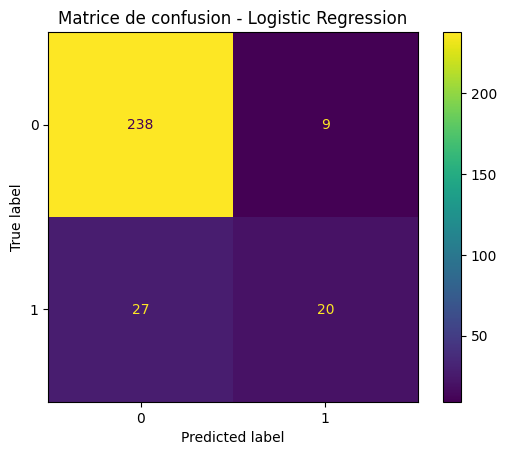

In [114]:
ConfusionMatrixDisplay.from_estimator(
    pipelines_without_redundancy["Logistic Regression"],
    X_test,
    y_test
)
plt.title("Matrice de confusion - Logistic Regression")

Text(0.5, 1.0, 'Matrice de confusion - Random Forest')

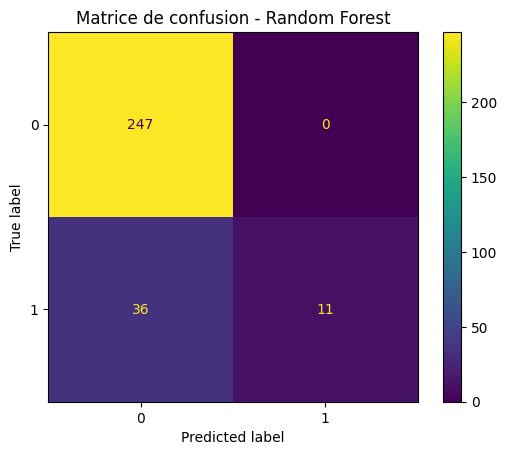

In [115]:
ConfusionMatrixDisplay.from_estimator(
    pipelines_without_redundancy["Random Forest"],
    X_test,
    y_test
)
plt.title("Matrice de confusion - Random Forest")

## Traitement du modèle linéaire

In [116]:
feature_selector = ("selector", SelectKBest())

pipeline_k_best = create_pipeline(
    preprocessor=preprocessor,
    model=LogisticRegression(max_iter=1000, class_weight="balanced"),
    model_name="K best logistic regression",
    extra_steps=[redundancy_selector, feature_selector],
)

pipeline_k_best.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('redundancy', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('oneHot', ...), ('ordinal', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [117]:
y_pred = pipeline_k_best.predict(X_test)
print("\n--- Rapport pour K best logistic regression ---")
print(classification_report(y_test, y_pred))


--- Rapport pour K best logistic regression ---
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       247
           1       0.37      0.79      0.51        47

    accuracy                           0.76       294
   macro avg       0.66      0.77      0.67       294
weighted avg       0.86      0.76      0.78       294



In [119]:
pipeline_grid = create_pipeline(
    preprocessor=preprocessor,
    model=LogisticRegression(class_weight="balanced", solver='liblinear', random_state=1234),
    model_name="logistic",
    extra_steps=[redundancy_selector, feature_selector],
)

grid_parameter = {
    'selector__k': ['all', 30, 25, 20, 15, 10, 5],
    'logistic__C': [0.01, 0.1, 1, 10, 100],
    'logistic__penalty': ['l1', 'l2']
}

grid = GridSearchCV(
    pipeline_grid,
    grid_parameter,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print(f"Meilleurs paramètres : {grid.best_params_}")
print(f"Meilleurs F1 scores en validation croisée: {grid.best_score_:.3f}")

Fitting 5 folds for each of 70 candidates, totalling 350 fits
Meilleurs paramètres : {'logistic__C': 0.1, 'logistic__penalty': 'l2', 'selector__k': 'all'}
Meilleurs F1 scores en validation croisée: 0.486


## Traitement du modèle non linéaire

In [120]:
pipeline_rf = create_pipeline(
    preprocessor=preprocessor,
    model=RandomForestClassifier(class_weight='balanced', random_state=1234),
    model_name="rf",
    extra_steps=[redundancy_selector]
)

pipeline_rf.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('redundancy', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('oneHot', ...), ('ordinal', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [121]:
y_pred = pipeline_rf.predict(X_test)
print("\n--- Rapport pour random forest balanced ---")
print(classification_report(y_test, y_pred))


--- Rapport pour random forest balanced ---
              precision    recall  f1-score   support

           0       0.86      1.00      0.93       247
           1       1.00      0.15      0.26        47

    accuracy                           0.86       294
   macro avg       0.93      0.57      0.59       294
weighted avg       0.88      0.86      0.82       294

